Text(0, 0.5, 'C')

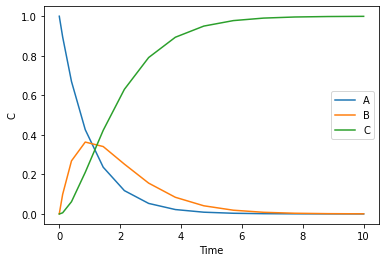

In [25]:
from scipy.integrate import solve_ivp

def ode(t, C):
    Ca, Cb, Cc = C
    dCadt = -k1 * Ca
    dCbdt = k1 * Ca - k2 * Cb
    dCcdt = k2 * Cb
    return [dCadt, dCbdt, dCcdt]

C0 = [1.0, 0.0, 0.0]
k1 = 1
k2 = 1

sol = solve_ivp(ode, (0, 10), C0)

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(sol.t, sol.y.T)
plt.legend(['A', 'B', 'C'])
plt.xlabel('Time')
plt.ylabel('C')

In [26]:
import autograd.numpy as np
from autograd import grad, elementwise_grad, jacobian
import autograd.numpy.random as npr
from autograd.misc.optimizers import adam

def init_random_params(scale, layer_sizes, rs=npr.RandomState(0)):
    """Build a list of (weights, biases) tuples, one for each layer."""
    return [(rs.randn(insize, outsize) * scale,   # weight matrix
             rs.randn(outsize) * scale)           # bias vector
            for insize, outsize in zip(layer_sizes[:-1], layer_sizes[1:])]

def swish(x):
    "see https://arxiv.org/pdf/1710.05941.pdf"
    return x / (1.0 + np.exp(-x))

def C(params, inputs):
    "Neural network functions"
    for W, b in params:
        outputs = np.dot(inputs, W) + b
        inputs = swish(outputs)
    return outputs

# initial guess for the weights and biases
params = init_random_params(0.1, layer_sizes=[1, 8, 3])

Text(0, 0.5, 'C')

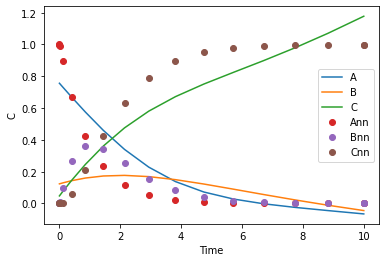

In [27]:
def objective_soln(params, step):
    return np.sum((sol.y.T - C(params, sol.t.reshape([-1, 1])))**2)

params = adam(grad(objective_soln), params,
              step_size=0.001, num_iters=500)

plt.plot(sol.t.reshape([-1, 1]), C(params, sol.t.reshape([-1, 1])),
         sol.t, sol.y.T, 'o')
plt.legend(['A', 'B', 'C', 'Ann', 'Bnn', 'Cnn'])
plt.xlabel('Time')
plt.ylabel('C')

In [28]:
jacC = jacobian(C, 1)
jacC(params, sol.t.reshape([-1, 1])).shape

(17, 3, 17, 1)

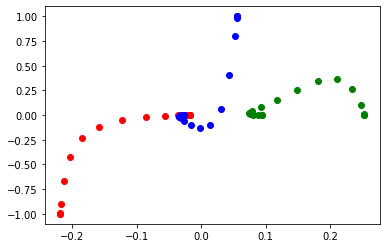

In [29]:
i = np.arange(len(sol.t))
plt.plot(jacC(params, sol.t.reshape([-1, 1]))[i, 0, i, 0],   -k1 * sol.y[0], 'ro')
plt.plot(jacC(params, sol.t.reshape([-1, 1]))[i, 1, i, 0],   -k2 * sol.y[1] + k1 * sol.y[0], 'bo')
plt.plot(jacC(params, sol.t.reshape([-1, 1]))[i, 2, i, 0],   k2 * sol.y[1], 'go')

In [41]:
# Derivatives
jac = jacobian(C, 1)
def dCdt(params, t):
    i = np.arange(len(t))
    return jac(params, t)[i, :, i].reshape((len(t), 3))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
jac(params, t):  (25, 3, 25, 1)
jac:  (25, 3, 1)


array([[-8.67351399e-03, -8.99553781e-03, -9.24718437e-04],
       [-8.15472418e-03, -8.48915848e-03, -9.75110988e-05],
       [-7.63607378e-03, -7.98412249e-03,  7.24571419e-04],
       [-7.11827787e-03, -7.48170738e-03,  1.53998323e-03],
       [-6.60205017e-03, -6.98317001e-03,  2.34721713e-03],
       [-6.08810074e-03, -6.48973716e-03,  3.14481314e-03],
       [-5.57713352e-03, -6.00259678e-03,  3.93136658e-03],
       [-5.06984388e-03, -5.52288960e-03,  4.70553540e-03],
       [-4.56691617e-03, -5.05170151e-03,  5.46604704e-03],
       [-4.06902126e-03, -4.59005663e-03,  6.21170436e-03],
       [-3.57681407e-03, -4.13891123e-03,  6.94139092e-03],
       [-3.09093116e-03, -3.69914846e-03,  7.65407540e-03],
       [-2.61198828e-03, -3.27157409e-03,  8.34881516e-03],
       [-2.14057814e-03, -2.85691311e-03,  9.02475898e-03],
       [-1.67726809e-03, -2.45580733e-03,  9.68114897e-03],
       [-1.22259805e-03, -2.06881387e-03,  1.03173216e-02],
       [-7.77078459e-04, -1.69640459e-03

In [38]:
t = np.linspace(0, 10, 25).reshape((-1, 1))
params = init_random_params(0.1, layer_sizes=[1, 8, 3])
i = 0    # number of training steps
N = 501  # epochs for training
et = 0.0 # total elapsed time

In [42]:
def objective(params, step):
    Ca, Cb, Cc = C(params, t).T
    dCadt, dCbdt, dCcdt = dCdt(params, t).T

    z1 = np.sum((dCadt + k1 * Ca)**2)
    z2 = np.sum((dCbdt - k1 * Ca + k2 * Cb)**2)
    z3 = np.sum((dCcdt - k2 * Cb)**2)
    ic = np.sum((np.array([Ca[0], Cb[0], Cc[0]]) - C0)**2)  # initial conditions
    return z1 + z2 + z3 + ic

def callback(params, step, g):
    if step % 100 == 0:
        print("Iteration {0:3d} objective {1}".format(step,
                                                      objective(params, step)))

objective(params, 0)  # make sure the objective is scalar

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
jac(params, t):  (25, 3, 25, 1)
jac:  (25, 3, 1)
dCadt:  (25,)


2.683379764003455

jac:  Autograd ArrayBox with value [[[[ 0.00751001]]

  [[ 0.00693293]]

  [[-0.0094667 ]]]]
dCadt:  (1,)
jac:  [[[[ 0.00751001]]

  [[ 0.00693293]]

  [[-0.0094667 ]]]]
dCadt:  (1,)
Iteration   0 objective 1.5202010772788654
jac:  Autograd ArrayBox with value [[[[ 0.00928457]]

  [[ 0.00347546]]

  [[-0.00799061]]]]
dCadt:  (1,)
jac:  Autograd ArrayBox with value [[[[ 1.09486011e-02]]

  [[ 1.68563202e-05]]

  [[-6.47435661e-03]]]]
dCadt:  (1,)
jac:  Autograd ArrayBox with value [[[[ 0.01238203]]

  [[-0.00344386]]

  [[-0.00493158]]]]
dCadt:  (1,)
jac:  Autograd ArrayBox with value [[[[ 0.01362965]]

  [[-0.00688649]]

  [[-0.00335174]]]]
dCadt:  (1,)
jac:  Autograd ArrayBox with value [[[[ 0.01480413]]

  [[-0.01030063]]

  [[-0.00172847]]]]
dCadt:  (1,)
jac:  Autograd ArrayBox with value [[[[ 1.59585121e-02]]

  [[-1.36806069e-02]]

  [[-5.59825008e-05]]]]
dCadt:  (1,)
jac:  Autograd ArrayBox with value [[[[ 0.01711233]]

  [[-0.01702488]]

  [[ 0.00167053]]]]
dCadt:  (1,)
jac:  Au

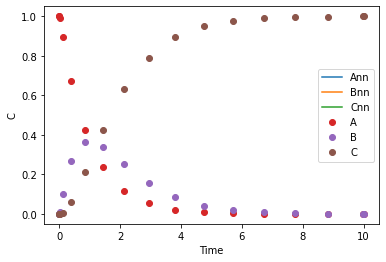

In [33]:
import time
t0 = time.time()

params = adam(grad(objective), params,
              step_size=0.005, num_iters=N, callback=callback)

i += N
t1 = (time.time() - t0) / 60
et += t1

plt.plot(t, C(params, t), sol.t, sol.y.T, 'o')
plt.legend(['Ann', 'Bnn', 'Cnn', 'A', 'B', 'C'])
plt.xlabel('Time')
plt.ylabel('C')
print(f'{t1:1.1f} minutes elapsed this time. Total time = {et:1.2f} min. Total epochs = {i}.')